In [60]:
# Import modules and set the calibration image path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import os.path as osp
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline


# Get Calibration Parameters
Input list of calibration images and get calibration parameters (mtx, dst)

In [2]:
def getCalibration(img_list):
    nx,ny = 9,6
    # --- convert the image to grayscale
    
    objpts_list = list()
    imgpts_list = list()
    
    objpts = np.zeros((nx*ny,3),np.float32)
    objpts[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    img_shape = (img_list[0].shape[1],img_list[0].shape[0])
    for ii,img in enumerate(img_list):
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # --- Find the chessboard corners
        # ret is simply a boolean return value that is true if the corners are found and false if otherwise
        foundCorners, imgpts = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    
        if foundCorners:
            # --- Prepare object points, (0,0,0), (1,0,0), (2,0,0), ... , (7,5,0)
            # initialize nx X ny of 3-tuples (x,y,z) with all zeros 
            
            objpts_list.append(objpts)
            imgpts_list.append(imgpts)
            #---- draw
            img_cp = np.copy(img)
            cv2.drawChessboardCorners(img_cp, (nx,ny), imgpts, foundCorners)
            plt.figure(figsize=[15,15])
            plt.subplot(1,2,1)
            plt.imshow(img)
            plt.title("Original ({})".format(ii))
            
            plt.subplot(1,2,2)
            plt.imshow(img_cp)
            plt.title("With Corners")
            
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts_list, imgpts_list, img_shape, None, None)
    return mtx,dist


### Load calibration images

In [3]:
def load_all_img_in_dir(dirname):
    img_paths = glob.glob(osp.join(dirname,"*.jpg"))
    img_list = [plt.imread(impath) for impath in img_paths]
    return img_list

In [4]:
cal_img_list = load_all_img_in_dir("./camera_cal")

### Calculate mtx and dist
Use images that have all 9 x 6 corners found. Plot the original image and an image with the corners drawn

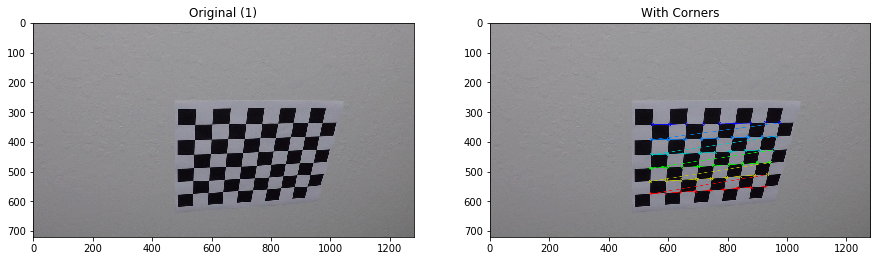

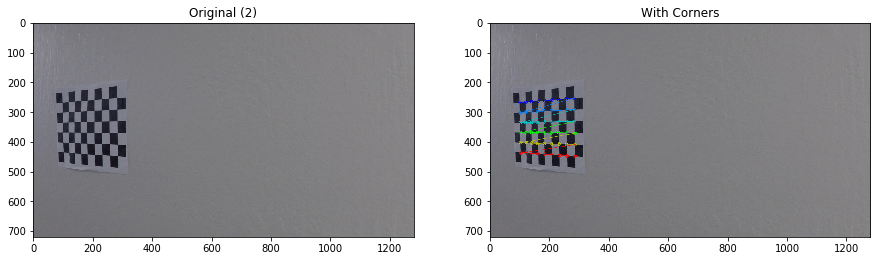

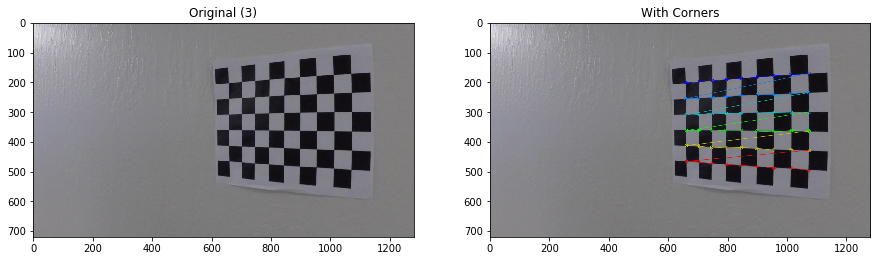

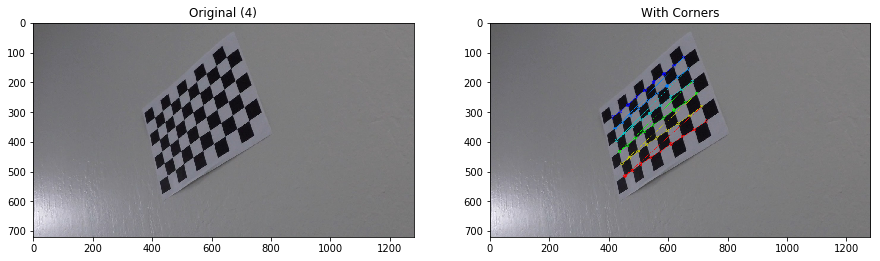

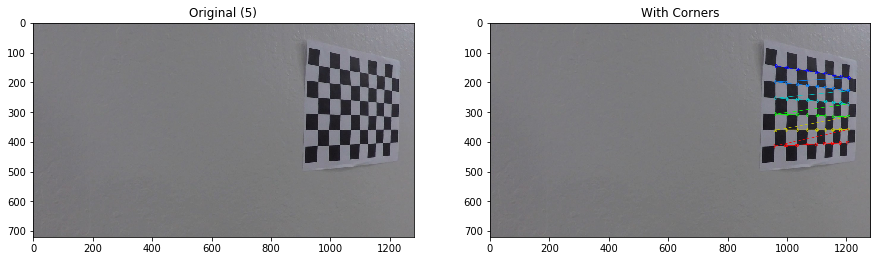

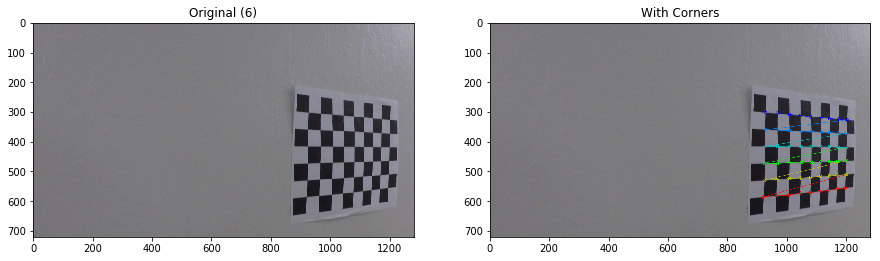

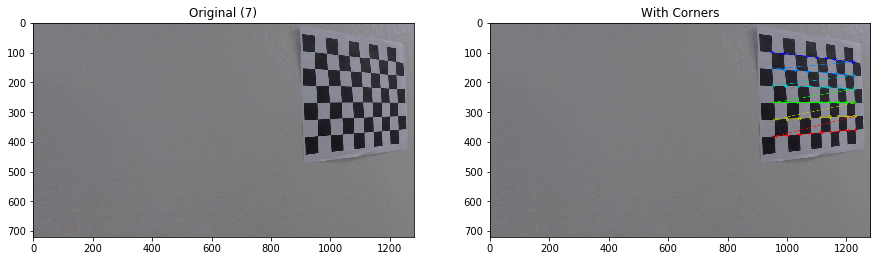

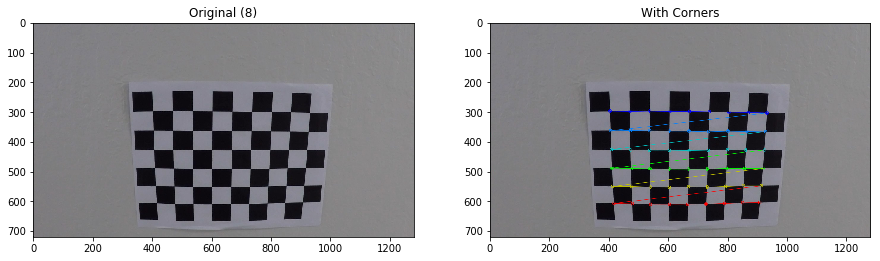

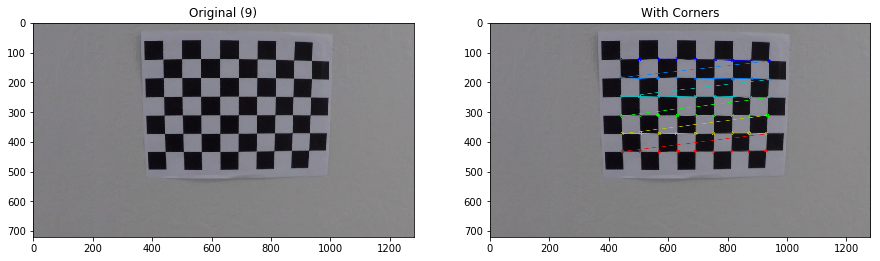

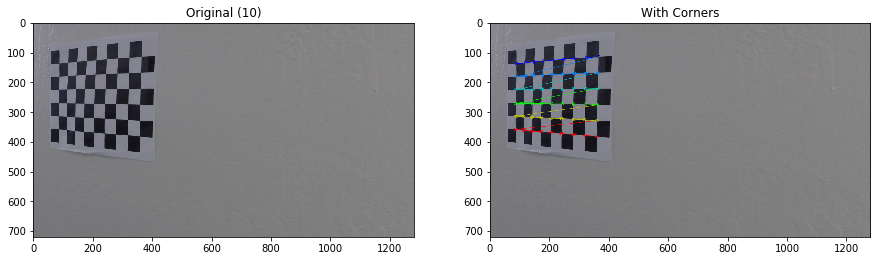

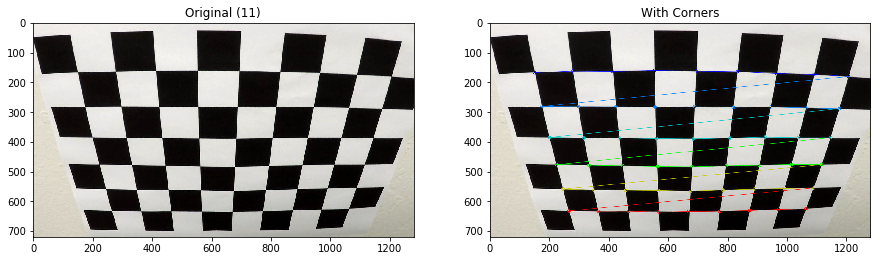

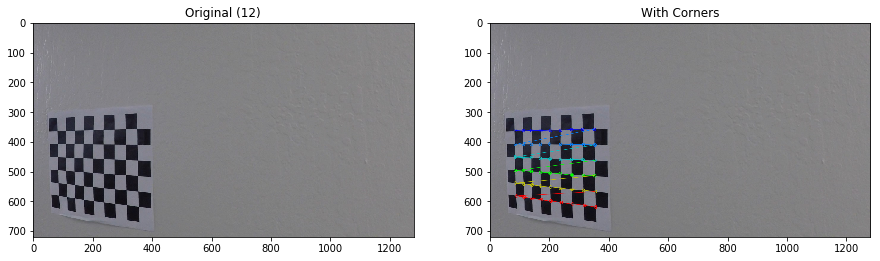

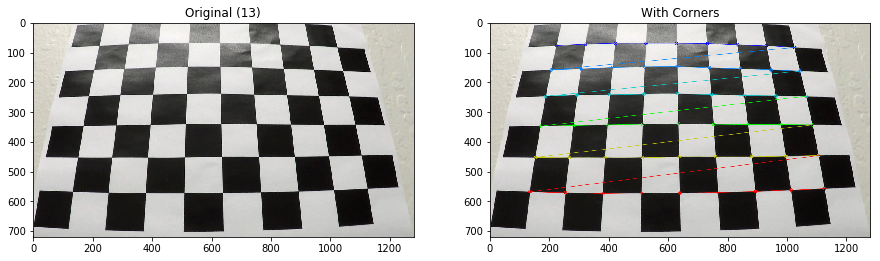

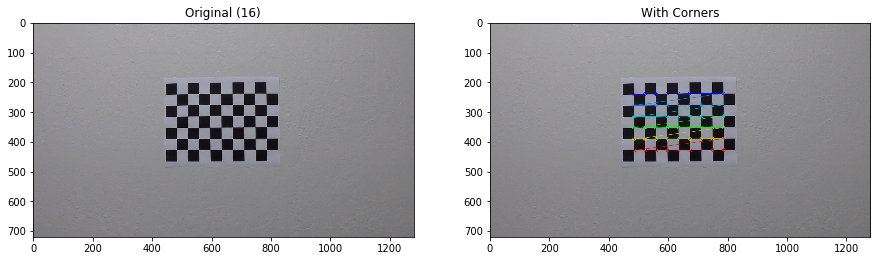

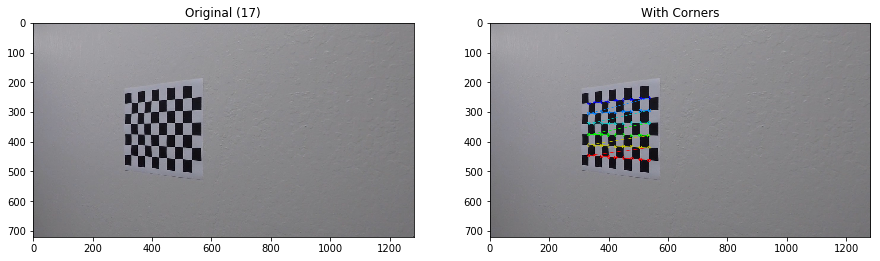

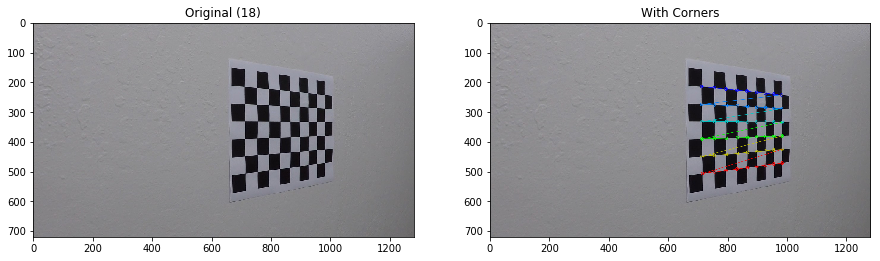

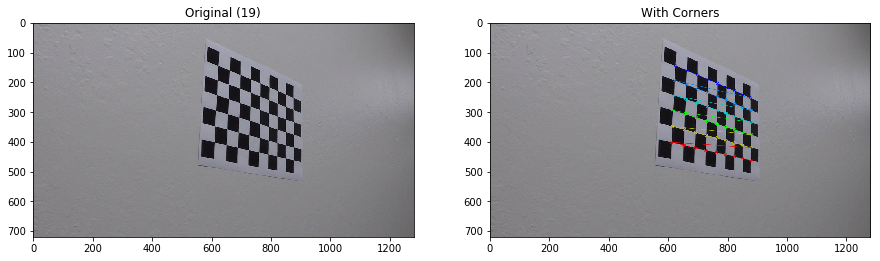

In [5]:
mtx,dist = getCalibration(cal_img_list)

In [6]:
print(mtx)

[[  1.15158804e+03   0.00000000e+00   6.66167057e+02]
 [  0.00000000e+00   1.14506859e+03   3.86440204e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [7]:
print(dist)

[[ -2.35510339e-01  -7.90388401e-02  -1.28492203e-03   8.25970403e-05
    7.22743173e-02]]


# Helper Functions

In [8]:
def undistort(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img
    
def getBirdsEyeView(img):
    ny,nx = img.shape[:2]
    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    dst = np.float32([(450,0),
                      (nx-450,0),
                      (450,ny),
                      (nx-450,ny)])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (nx,ny), flags=cv2.INTER_LINEAR)
    return warped
    
    
def getReverseBirdsEyeView(img):
    ny,nx = img.shape[:2]
    dst = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    src = np.float32([(450,0),
                      (nx-450,0),
                      (450,ny),
                      (nx-450,ny)])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (nx,ny), flags=cv2.INTER_LINEAR)
    return warped
    
    
    
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=5, thresh_max=100):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output#binary_output
    
def sobel_dir(img, sobel_kernel=21,thresh=(np.pi/4,np.pi/3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output    
    
def abs_sobel_x(img, thresh=(10,150)):
    return abs_sobel_thresh(img,orient='x',thresh_min=thresh[0],thresh_max=thresh[1])
    
def abs_sobel_y(img, thresh=(20,150)):
    return abs_sobel_thresh(img,orient='y',thresh_min=thresh[0],thresh_max=thresh[1])

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(100, 255),ind=2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,ind]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

def lab_select(img, thresh=(190,255),ind=2):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_out = lab[:,:,ind]
    # don't normalize if there are no yellows in the image
    if np.max(lab_out) > 175:
        lab_out = lab_out*(255/np.max(lab_out))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_out)
    binary_output[((lab_out > thresh[0]) & (lab_out <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return np.array(binary_output,dtype=np.uint8)

def white_select(img,thresh=(200,255)):
    return cv2.inRange(img,np.array([thresh[0]]*3),np.array([thresh[1]]*3))
    
    
def mask_LR(img):
    mask = np.zeros_like(img)  
    offset = 200
    ny,nx = img.shape[:2]
    vertices = np.array([[(offset,ny),
                          (nx-offset,ny),
                          (nx-offset,0),
                          (offset,0)]])
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
    

def gaussian_blur(img, kernel_size=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)



# Undistort and Birds-eye-view of test images

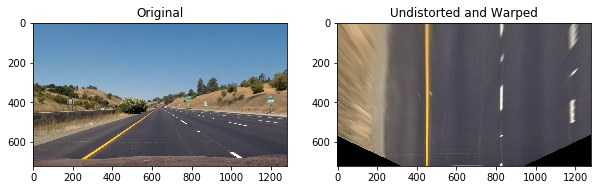

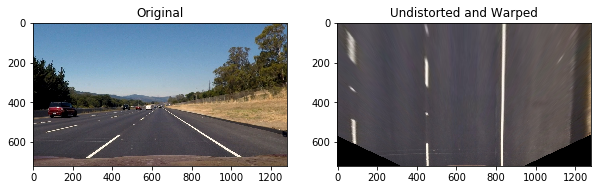

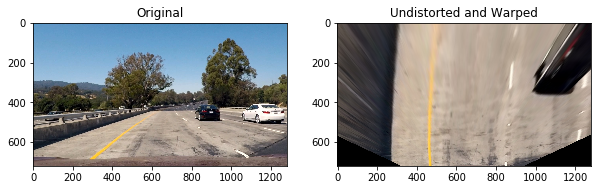

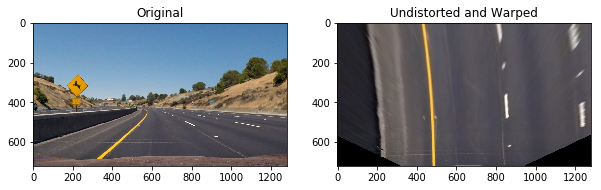

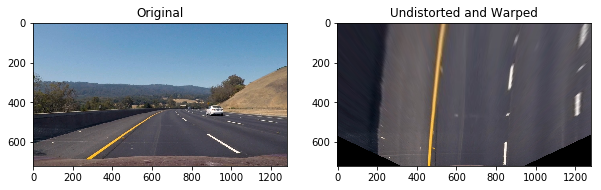

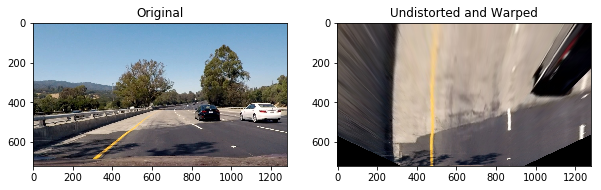

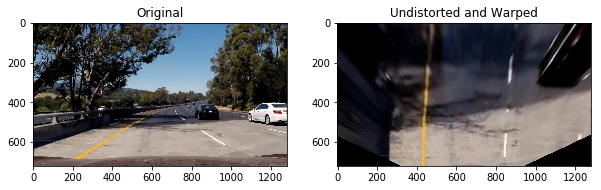

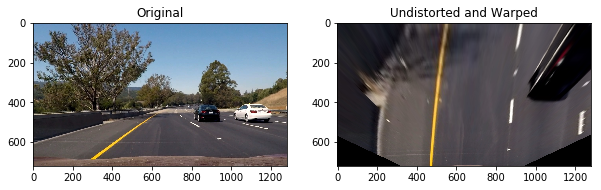

In [9]:
test_img_list = load_all_img_in_dir("./test_images")

for test_img in test_img_list:
    plt.figure(figsize=[10,10])
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(test_img)
    
    plt.subplot(1,2,2)
    plt.title("Undistorted and Warped")
    plt.imshow(getBirdsEyeView(undistort(test_img)))

# Visualize Lane Line Isolation

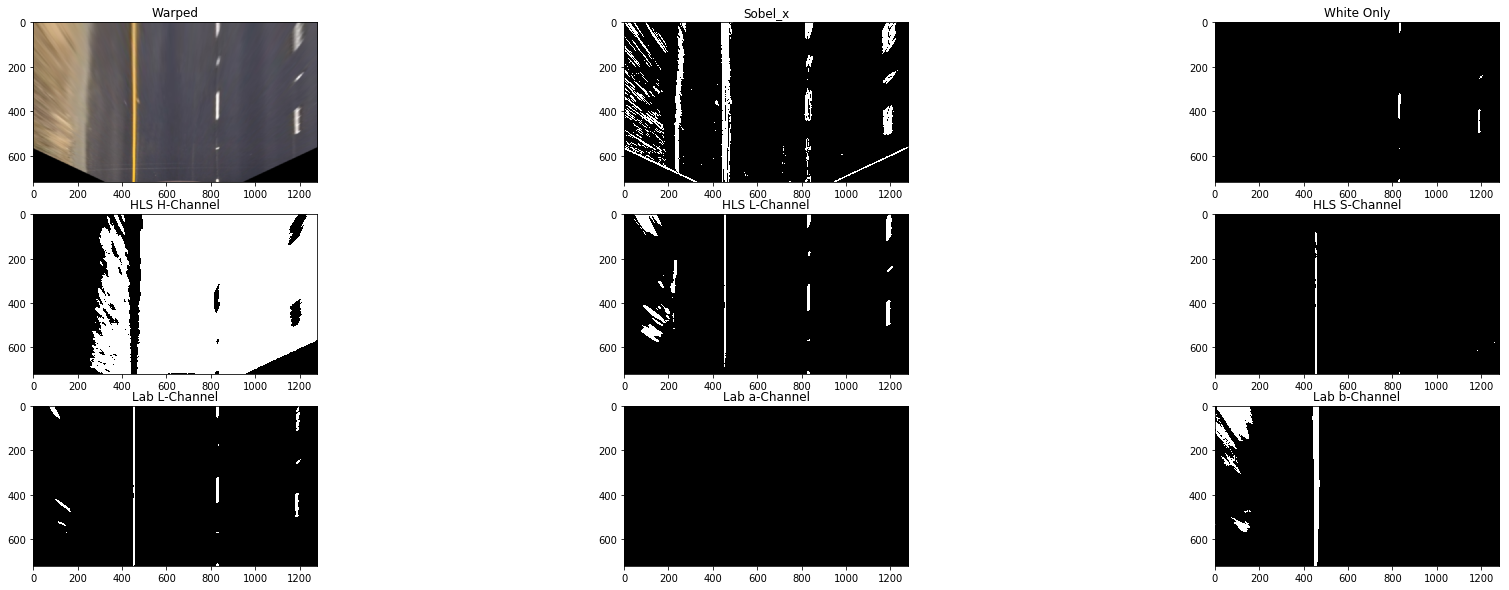

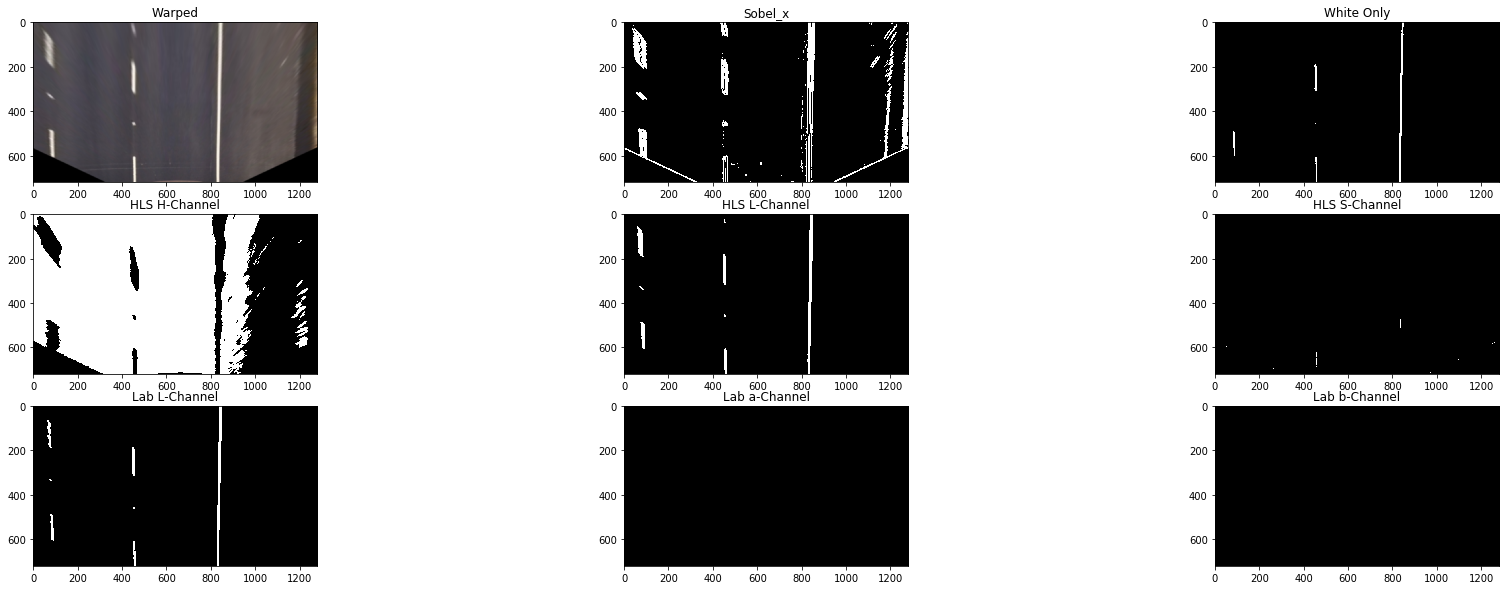

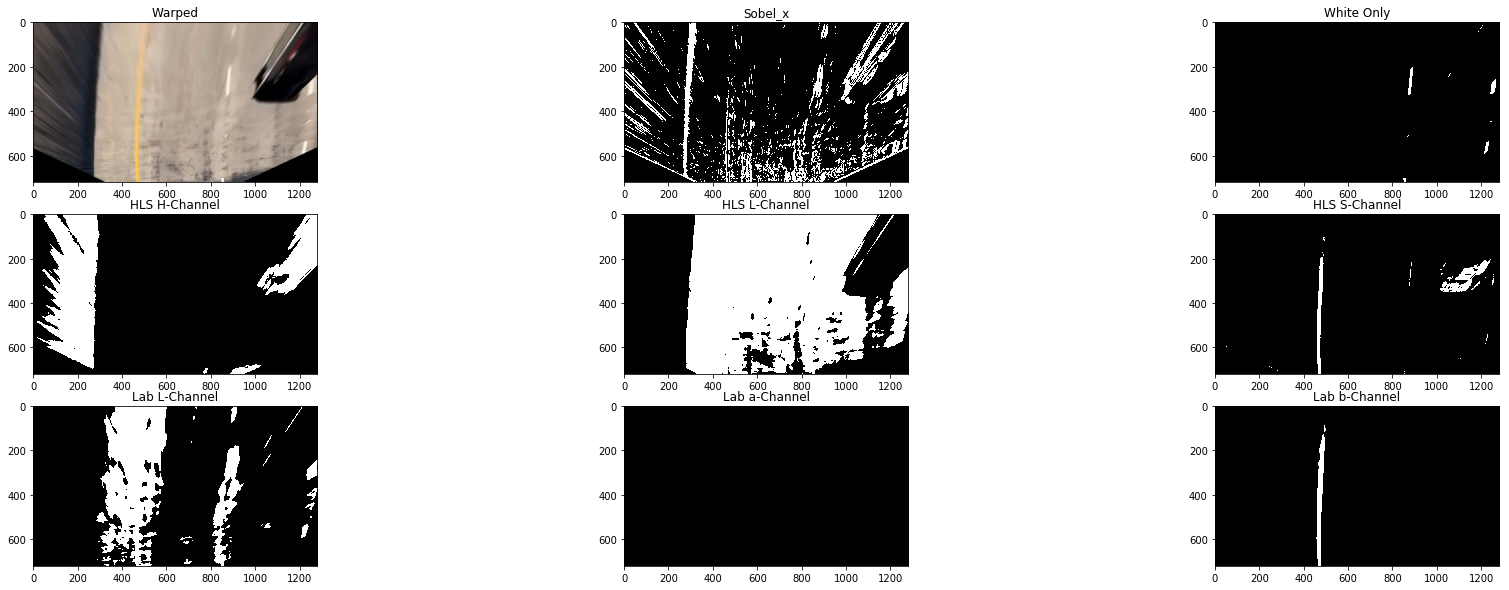

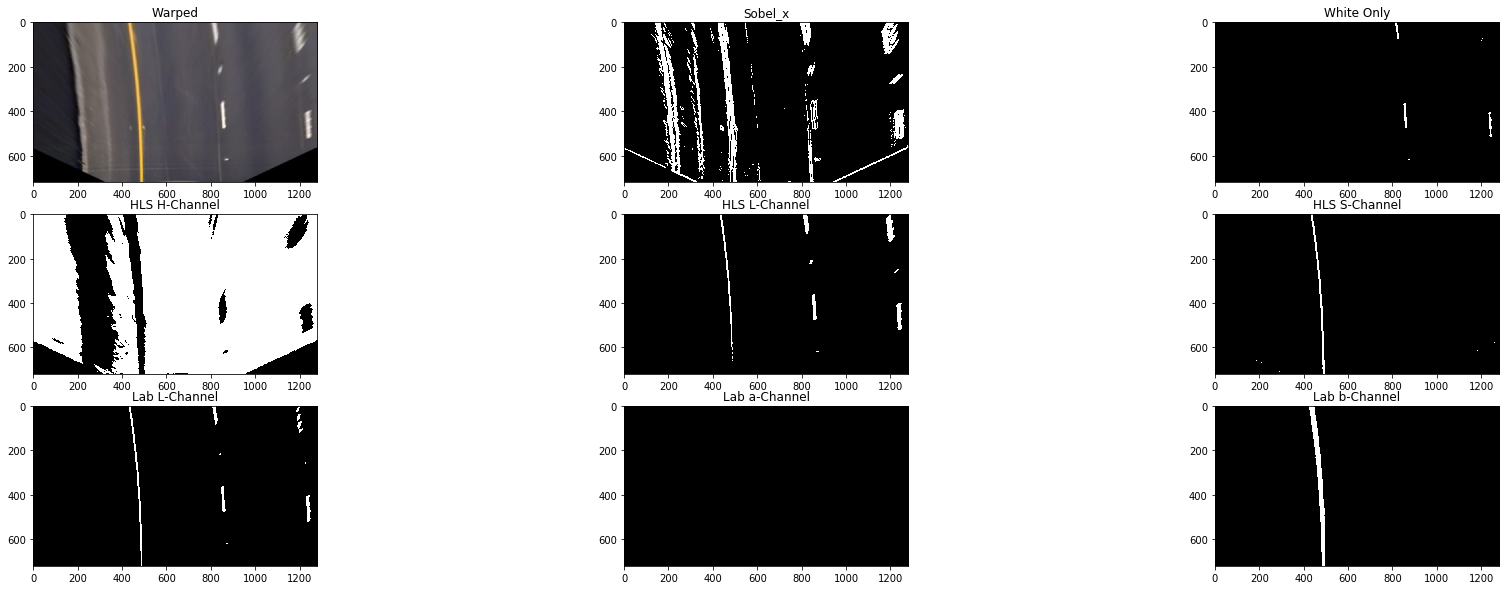

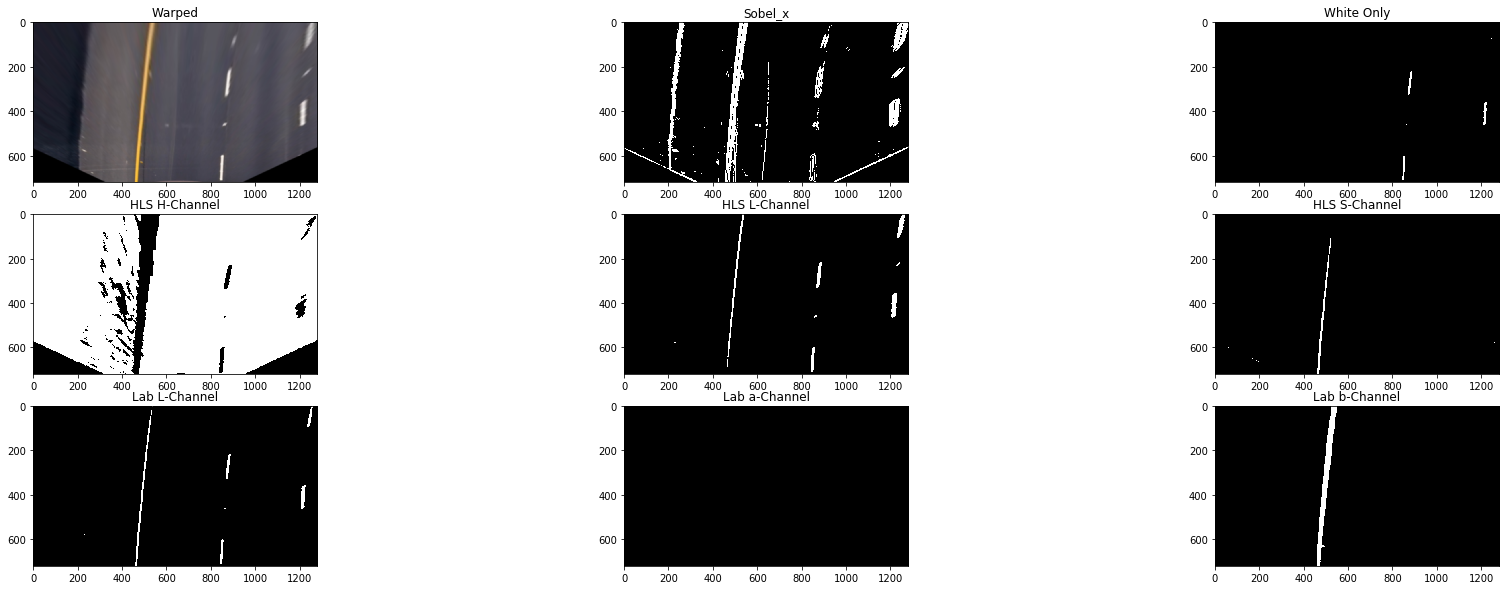

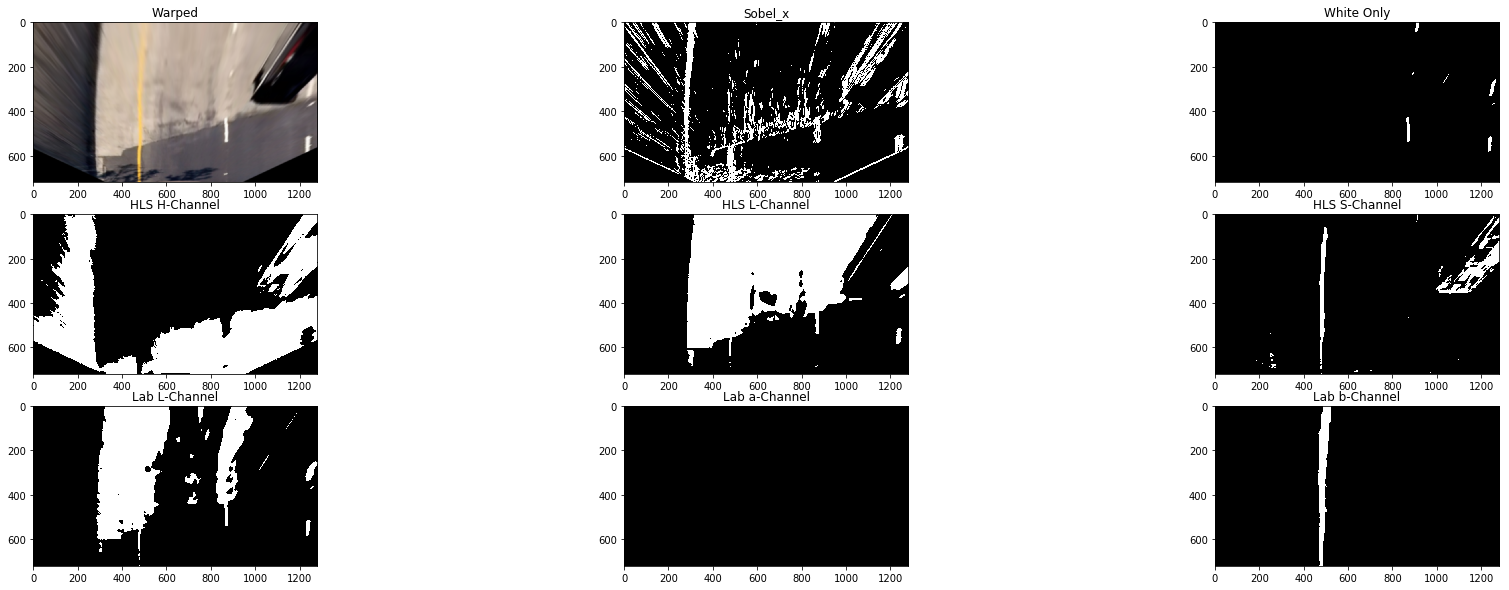

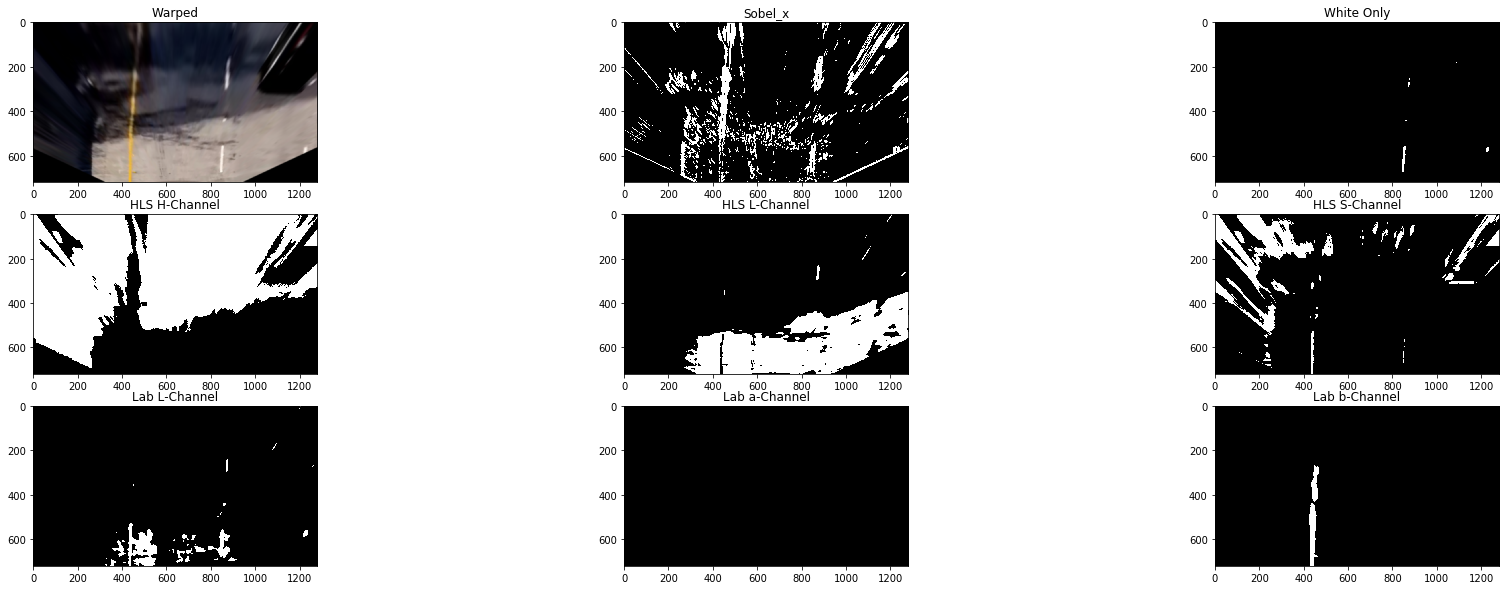

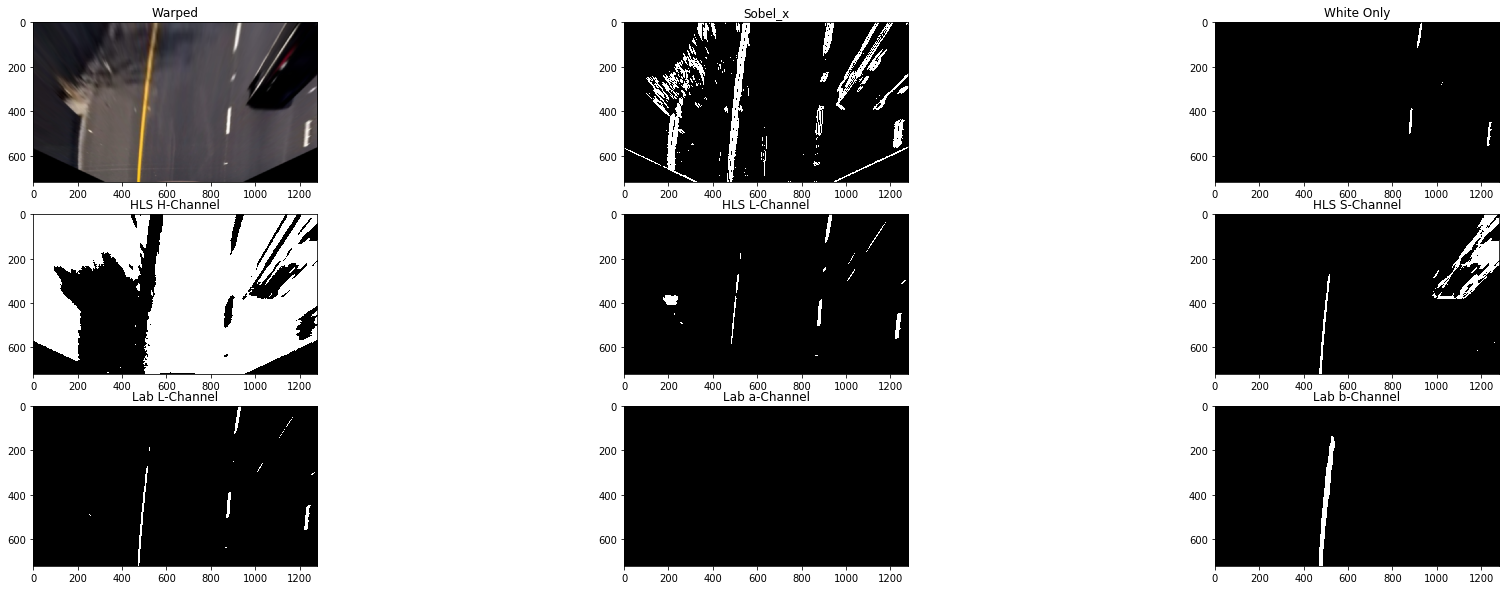

In [10]:
for img in test_img_list:
    warped = getBirdsEyeView(undistort(img))
    warped = gaussian_blur(warped,kernel_size=11)
    sobelx = abs_sobel_x(warped)
    sobely = abs_sobel_y(warped)
    sobelDir = sobel_dir(warped)
    
    white_only = white_select(warped)
    
    hls_h = hls_select(warped,ind=0)
    hls_l = hls_select(warped,ind=1,thresh=(155,255))
    hls_s = hls_select(warped,ind=2,thresh=(155,255))
    
    lab_l = lab_select(warped,ind=0)
    lab_a = lab_select(warped,ind=1)
    lab_b = lab_select(warped,ind=2)
    
    
    
    plt.figure(figsize=[30,10])
    plt.subplot(3,3,1)
    plt.imshow(warped)
    plt.title("Warped")
    
    plt.subplot(3,3,2)
    plt.imshow(sobelx,cmap='gray')
    plt.title("Sobel_x")
    
    plt.subplot(3,3,3)
    plt.imshow(white_only,cmap='gray')
    plt.title("White Only")
    
    plt.subplot(3,3,4)
    plt.imshow(hls_h,cmap='gray')
    plt.title("HLS H-Channel")
    
    plt.subplot(3,3,5)
    plt.imshow(hls_l,cmap='gray')
    plt.title("HLS L-Channel")
    
    plt.subplot(3,3,6)
    plt.imshow(hls_s,cmap='gray')
    plt.title("HLS S-Channel")
    
    plt.subplot(3,3,7)
    plt.imshow(lab_l,cmap='gray')
    plt.title("Lab L-Channel")
    
    plt.subplot(3,3,8)
    plt.imshow(lab_a,cmap='gray')
    plt.title("Lab a-Channel")
    
    plt.subplot(3,3,9)
    plt.imshow(lab_b,cmap='gray')
    plt.title("Lab b-Channel")
    
    

    
    
    

# Combine Filters

Since we are missing the white lanes in many of the color space filters, I included the white-only filter

In [11]:
def combineFilters(img):
    hls_s = hls_select(img,ind=2)
    lab_l = lab_select(img,ind=0)
    lab_b = lab_select(img,ind=2)
    white = white_select(img)
    
    output = (white | (hls_s & lab_b)  )  & lab_l

    return output
    

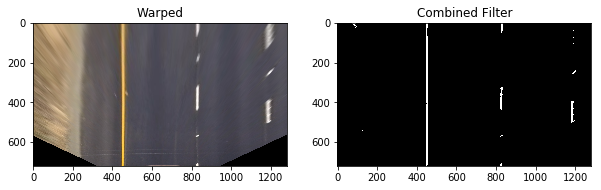

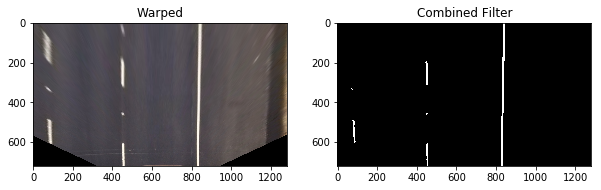

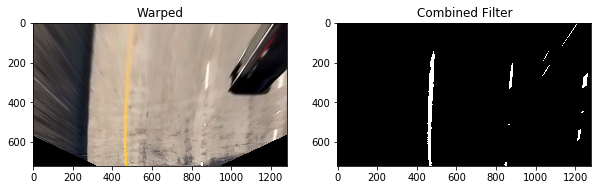

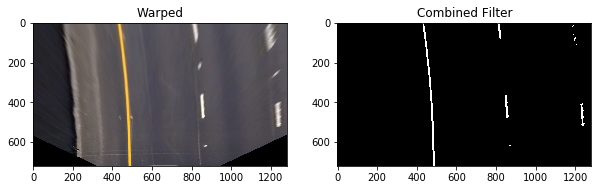

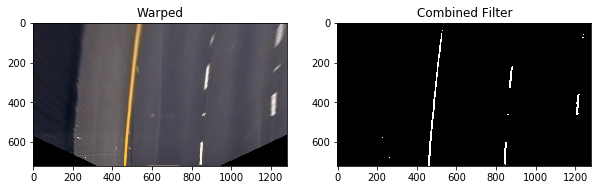

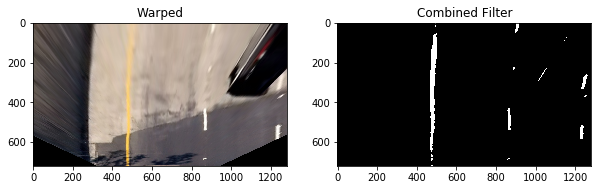

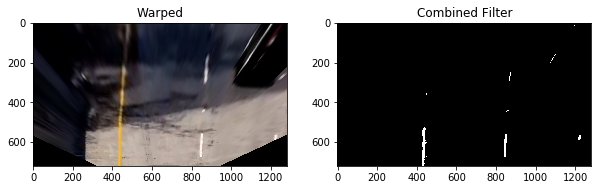

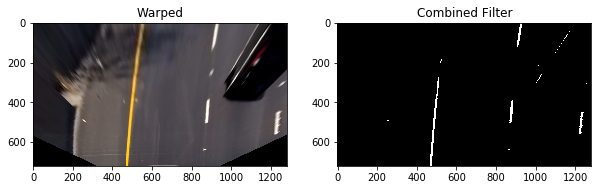

In [12]:
for img in test_img_list:
    warped = getBirdsEyeView(undistort(img))
    plt.figure(figsize=[10,10])
    plt.subplot(1,2,1)
    plt.imshow(warped)
    plt.title("Warped")
    
    plt.subplot(1,2,2)
    plt.imshow(combineFilters(warped),cmap='gray')
    plt.title("Combined Filter")

# Image Processing Pipeline

0. Undistort the image 
1. Perspective Transform (Bird's eye view)
2. Filter out the lane lines using different colorspace
4. Crop the left and right pixels to remove neighboring lanes

In [13]:
def pipeline(img):
    img_undist = undistort(img)
    img_warp = getBirdsEyeView(img_undist)
    img_lanes = combineFilters(img_warp)
    return mask_LR(img_lanes)

# Get Curvature

In [14]:
def slidingWindows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     vis
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit,right_fit,out_img

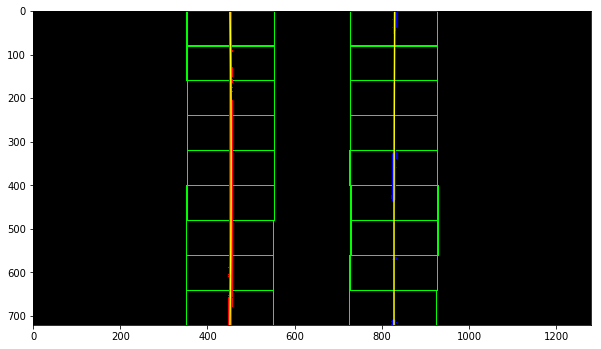

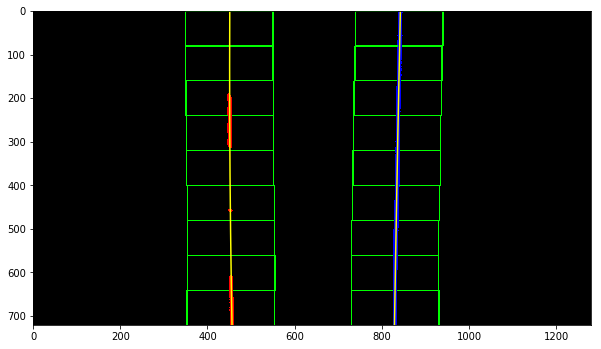

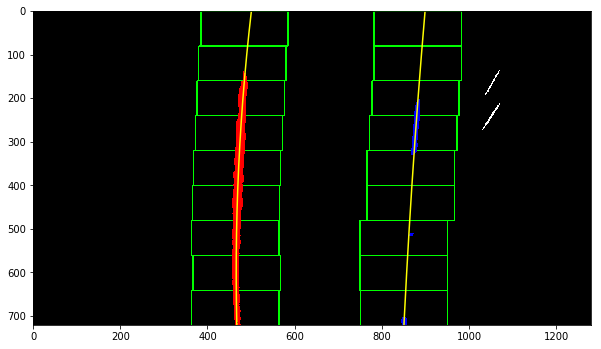

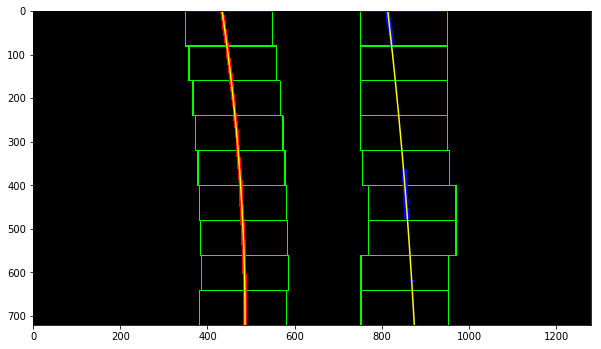

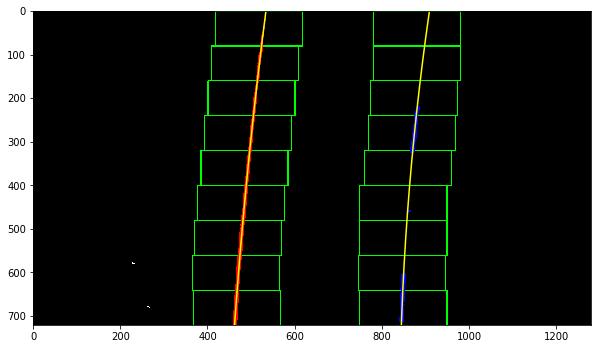

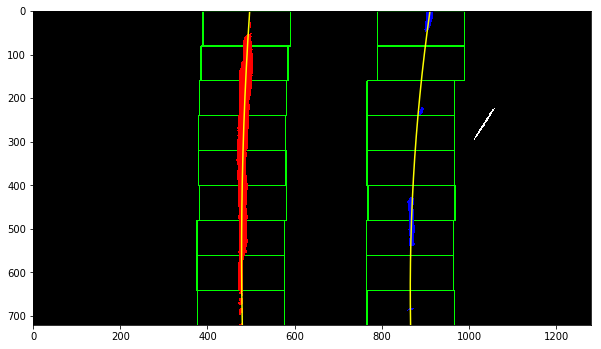

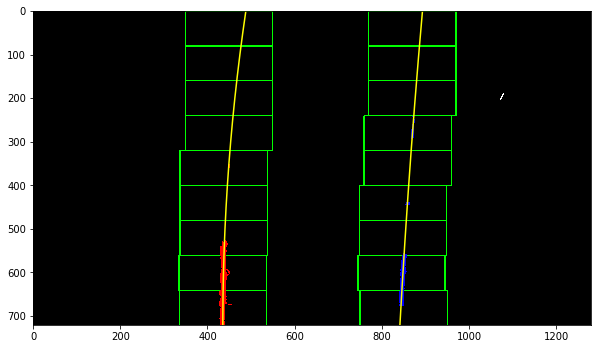

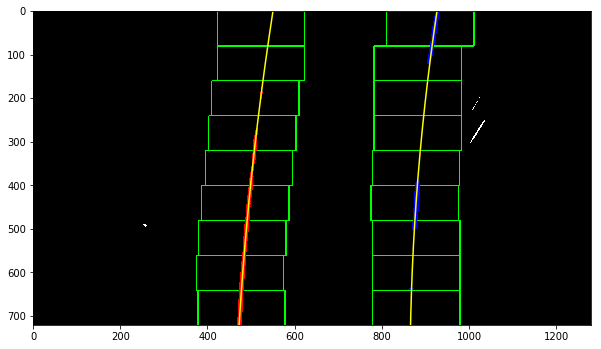

In [15]:
for img in test_img_list:
    binary_warped = pipeline(img)
    left_fit,right_fit,out_img = slidingWindows(binary_warped)
    plt.figure(figsize=[10,10])

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

# Calculate Curvature in Meters

In [52]:
def calculateCurvature_meter(img,):
    binary_warped = pipeline(img)
    ny,nx = binary_warped.shape[:2]
    y_eval = img.shape[0]
    left_fit,right_fit,out_img = slidingWindows(binary_warped)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, ny-1, num=ny)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 3.048/100
    xm_per_pix = 3.7/378
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    if right_fit_cr is not None and left_fit_cr is not None:
        car_position = binary_warped.shape[1]/2
        l_fit_x_int = left_fit[0]*ny**2 + left_fit[1]*ny + left_fit[2]
        r_fit_x_int = right_fit[0]*ny**2 + right_fit[1]*ny + right_fit[2]

        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        d_center = (car_position - lane_center_position) * xm_per_pix
    return left_fit,right_fit,out_img,left_curverad,right_curverad,d_center

In [53]:
def getImgWithFillBetweenLanes(img):
    left_fit,right_fit,out_img,left_curverad,right_curverad,d_center = calculateCurvature_meter(img)
    undist = undistort(img)
    warped = pipeline(img)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    y_eval = img.shape[0]
    left_fit,right_fit,out_img = slidingWindows(warped)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp = getReverseBirdsEyeView(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result,left_curverad,right_curverad,d_center

# Process each frame

In [54]:
def processFrame(img):
    result,left_curverad,right_curverad,d_center = getImgWithFillBetweenLanes(img)
    radius_curve = (left_curverad+right_curverad)/2
#     carPosition_str = "Left" if curveRad < 0 else "Right"
    text0 = "Radius of Curvature  : {:1.4f} m".format(radius_curve)
    text1 = "Distance From Center : {:1.4f} m ".format(d_center)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result, text0, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(result, text1, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return result
#     
    

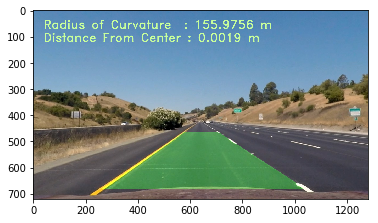

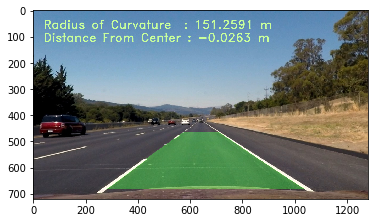

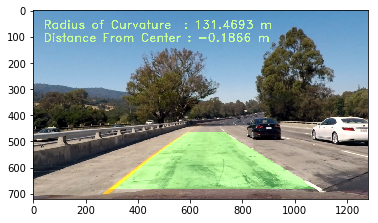

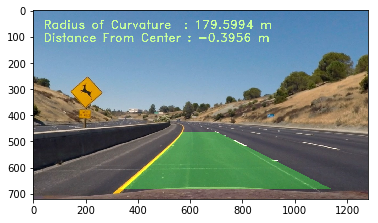

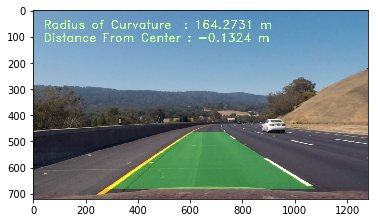

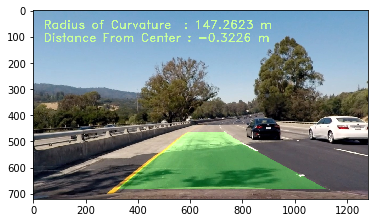

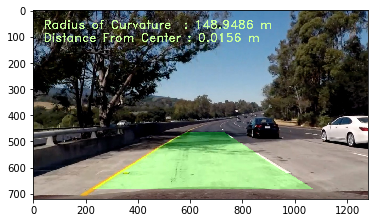

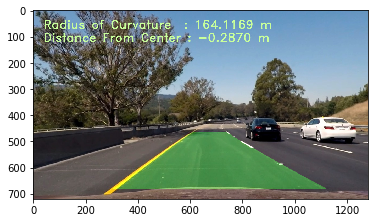

In [55]:
for img in test_img_list:
    fill_img = processFrame(img)
    plt.figure()
    plt.imshow(fill_img)

451.61560829 828.005142036
456.350877812 829.031614682
467.342187072 850.774797651
486.397551612 874.429449734
462.210301738 844.851430479
479.964844416 865.958633498
435.278735074 841.52495664
472.695623813 865.943692601


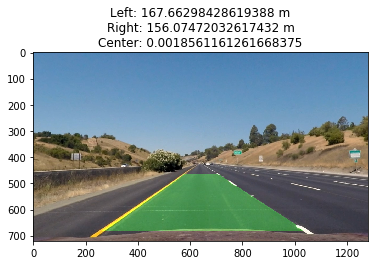

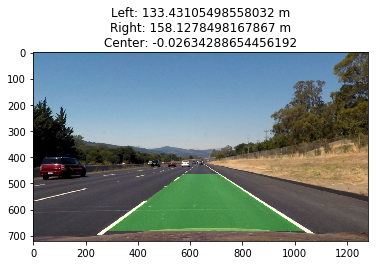

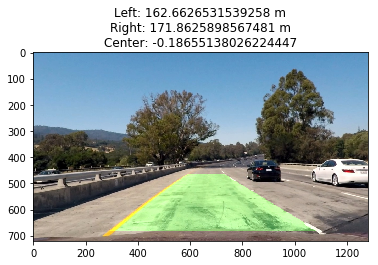

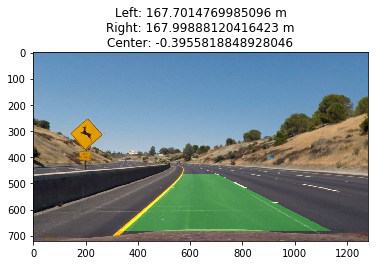

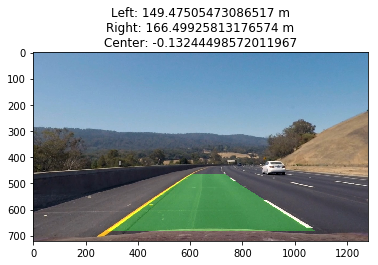

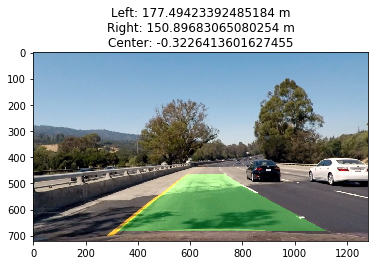

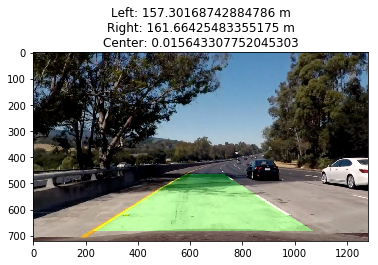

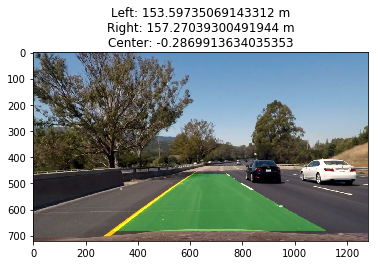

In [42]:
for img in test_img_list:
    fill_img,left_curverad,right_curverad,d_center = getImgWithFillBetweenLanes(img)
    plt.figure()
    plt.imshow(fill_img)
    plt.title("Left: {} m\nRight: {} m\nCenter: {}".format(left_curverad,right_curverad,d_center))

In [61]:
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(processFrame)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:34<00:00,  4.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 24s, sys: 45.2 s, total: 7min 9s
Wall time: 4min 35s
